***Import Modules***

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import itertools
import os

***Load in data for various companies***

In [2]:
#Companies: AAPL, GOOG, FB, IBM, BB, MSFT, SAMSUNG
dataframes = [pd.read_csv('AAPL.csv'), pd.read_csv('GOOG.csv'), pd.read_csv('FB.csv'), pd.read_csv('IBM.csv'), pd.read_csv('BB.csv'), pd.read_csv('MSFT.csv'), pd.read_csv('SAMSUNG.csv')]
data = [df.values for df in dataframes]

***Feature engineering***

In [3]:
#REQUIREMENTS: LONG_MA_LENGTH > SHORT_MA_LENGTH (Important Note: the inequality is strict)

DAYS_AHEAD = 7
SHORT_MA_LENGTH = 10
LONG_MA_LENGTH = 50

processed_data = np.array([]).reshape(0,6) #Second value equals number of features
for company in data:
    company_data = []
    closes = (company.T)[4]
    
    #Get Short-Term Moving Averages
    mas = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH+1):
        ma = sum([closes[j] for j in range(i+1, i+SHORT_MA_LENGTH)])/SHORT_MA_LENGTH #average close of last SHORT_MA_LENGTH days
        mas.append(ma)
    mas = np.array(mas)
    company_data.append(mas[:-1])
    
    #Get Changes in Short-Term Moving Average
    delta_mas = []
    for i in range(company.shape[0]-LONG_MA_LENGTH-DAYS_AHEAD):
        delta_mas.append(mas[i]-mas[i+1]) #todays MA minus yesterdays MA
    delta_mas = np.array(delta_mas)
    company_data.append(delta_mas)
    
    #Get Long-Term Moving Averages
    mas = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH+1):
        ma = sum([closes[j] for j in range(i+1, i+LONG_MA_LENGTH)])/LONG_MA_LENGTH #average close of last SHORT_MA_LENGTH days
        mas.append(ma)
    mas = np.array(mas)
    company_data.append(mas[:-1])
    
    #Get Changes in Long-Term Moving Average
    delta_mas = []
    for i in range(company.shape[0]-LONG_MA_LENGTH-DAYS_AHEAD):
        delta_mas.append(mas[i]-mas[i+1]) #todays MA minus yesterdays MA
    delta_mas = np.array(delta_mas)
    company_data.append(delta_mas)
    
    #Get Last Day Volumes (perhaps change to OBV)
    volumes = company.T[-1][DAYS_AHEAD+1:company.shape[0]-LONG_MA_LENGTH+1]
    company_data.append(volumes)
    
    #Get directions
    directions = []
    for i in range(DAYS_AHEAD, company.shape[0]-LONG_MA_LENGTH):
        diff = closes[i-DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    company_data.append(directions)
    
    company_data = np.array(company_data).T
    processed_data = np.vstack((processed_data, company_data))

In [4]:
data[0]

array([['2014-03-21', 75.989998, 76.25, ..., 76.12428299999999,
        67.315308, 93511600],
       ['2014-03-24', 76.91714499999999, 77.214287, ...,
        77.02714499999999, 68.113724, 88925200],
       ['2014-03-25', 77.35714, 77.964287, ..., 77.855713, 68.846397,
        70573300],
       ...,
       ['2019-03-19', 188.350006, 188.990005, ..., 186.529999,
        186.529999, 31646400],
       ['2019-03-20', 186.229996, 189.490005, ..., 188.16000400000001,
        188.16000400000001, 31035200],
       ['2019-03-21', 190.020004, 196.330002, ..., 195.08999599999999,
        195.08999599999999, 50980100]], dtype=object)

In [5]:
processed_data

array([[67.9308577, 0.351285500000003, 81.89891496000001,
        -0.29565719999999374, 45105200, 'down'],
       [67.5795722, 0.2825713999999948, 82.19457216, -0.2861999600000189,
        40586000, 'down'],
       [67.2970008, 0.09828570000001946, 82.48077212000003,
        -0.32451415999997835, 68812800, 'up'],
       ...,
       [38535.0, 180.0, 40131.0, -55.0, 7538720, 'down'],
       [38355.0, -45.0, 40186.0, -67.0, 9420664, 'up'],
       [38400.0, -5.0, 40253.0, -85.0, 10769589, 'up']], dtype=object)

***Scaling, Oversampling and Train Test Split***

In [6]:
ys = processed_data.T[-1]
xs = processed_data.T[:-1].T

scaler = StandardScaler()
xs = scaler.fit_transform(xs)

smote = SMOTE(random_state = 1729)
xs, ys = smote.fit_resample(xs, ys)

test_xs = xs[:int((1/7)*xs.shape[0])]
test_ys = ys[:int((1/7)*xs.shape[0])]
train_xs = xs[int((1/7)*xs.shape[0]):]
train_ys = ys[int((1/7)*xs.shape[0]):]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


***Train Model***

In [7]:
clf = svm.SVC(C = 13.5, gamma = 'scale', random_state = 42)
clf.fit(train_xs, train_ys)

SVC(C=13.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

***Get Accuracy (current: accuracy = 58%, recall = 60%, precision = 58%, f1 = 59%, true_negative = 56%)***

In [8]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))

down pred: 692 up pred: 605
down test: 726 up test: 571
Out of a total of 1297 samples, 755 were correct


***Plot Confusion Matrix***

Normalized confusion matrix
[[0.60330579 0.39669421]
 [0.44483363 0.55516637]]


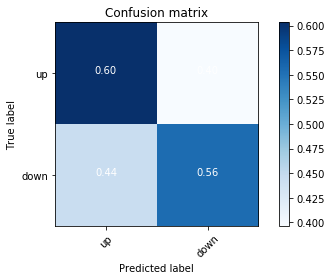

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)